# K Means Clustering

### Importing libraries

In [14]:
from sklearn.datasets import make_blobs
import numpy as np
from pyspark.sql.functions import monotonically_increasing_id
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pyspark
spark = pyspark.sql.SparkSession.builder.appName("K-means Clustering").getOrCreate()

### Creating synthetic dataset

In [15]:
features, true_labels = make_blobs(
   ...:     n_samples=200,
   ...:     centers=3,
   ...:     cluster_std=2.75,
   ...:     random_state=42
   ...: )

### Displaying the dataset

In [16]:
features[0:5]

array([[  9.77075874,   3.27621022],
       [ -9.71349666,  11.27451802],
       [ -6.91330582,  -9.34755911],
       [-10.86185913, -10.75063497],
       [ -8.50038027,  -4.54370383]])

### Create Spark Dataframe with columns 'feature1', 'feature2' and 'id'
### Create Spark Dataframe with columns 'label' and 'id'

In [17]:
df1 = spark.createDataFrame(features,['feature1','feature2'])
df1 = df1.withColumn("id1", monotonically_increasing_id())
df2 = spark.createDataFrame(true_labels,['label'])
df2 = df2.withColumn("id1", monotonically_increasing_id())

### Joining the two dataframes

In [18]:
df = df1.join(df2,on="id1")
df.show(5)

+---+------------------+------------------+-----+
|id1|          feature1|          feature2|label|
+---+------------------+------------------+-----+
|  0| 9.770758741876183|3.2762102164481477|    1|
|  7|-8.174982531601657|-6.241972265542447|    2|
|  6|-3.038190276200837| 9.843541319615756|    0|
|  9| -4.64425636434413|-5.148630277986013|    2|
|  5|  -4.8245697770623|-5.201591363333918|    2|
+---+------------------+------------------+-----+
only showing top 5 rows



### Preprocessing, Scaling and transformation

In [19]:
assembler = VectorAssembler(inputCols=["feature1", "feature2"],
                            outputCol="features")
data_df = assembler.transform(df)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_df)
data_df = scaler_model.transform(data_df)
data_df.show(5)

+---+------------------+------------------+-----+--------------------+--------------------+
|id1|          feature1|          feature2|label|            features|     scaled_features|
+---+------------------+------------------+-----+--------------------+--------------------+
|  0| 9.770758741876183|3.2762102164481477|    1|[9.77075874187618...|[1.82968666370121...|
|  7|-8.174982531601657|-6.241972265542447|    2|[-8.1749825316016...|[-1.5308592617229...|
|  6|-3.038190276200837| 9.843541319615756|    0|[-3.0381902762008...|[-0.5689359830702...|
|  9| -4.64425636434413|-5.148630277986013|    2|[-4.6442563643441...|[-0.8696902827239...|
|  5|  -4.8245697770623|-5.201591363333918|    2|[-4.8245697770623...|[-0.9034560377950...|
+---+------------------+------------------+-----+--------------------+--------------------+
only showing top 5 rows



### K-Means Clustering

In [20]:
kmeans = KMeans(k=3, featuresCol="scaled_features", predictionCol="cluster")
model = kmeans.fit(data_df)

24/07/02 17:05:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


### Model predictions and display

In [21]:
predictions = model.transform(data_df)
predictions.show(5)

+---+------------------+------------------+-----+--------------------+--------------------+-------+
|id1|          feature1|          feature2|label|            features|     scaled_features|cluster|
+---+------------------+------------------+-----+--------------------+--------------------+-------+
|  0| 9.770758741876183|3.2762102164481477|    1|[9.77075874187618...|[1.82968666370121...|      0|
|  7|-8.174982531601657|-6.241972265542447|    2|[-8.1749825316016...|[-1.5308592617229...|      1|
|  6|-3.038190276200837| 9.843541319615756|    0|[-3.0381902762008...|[-0.5689359830702...|      2|
|  9| -4.64425636434413|-5.148630277986013|    2|[-4.6442563643441...|[-0.8696902827239...|      1|
|  5|  -4.8245697770623|-5.201591363333918|    2|[-4.8245697770623...|[-0.9034560377950...|      1|
+---+------------------+------------------+-----+--------------------+--------------------+-------+
only showing top 5 rows



### Evaluating the model

In [22]:
evaluator = ClusteringEvaluator(predictionCol='cluster', featuresCol='scaled_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
#evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette_score:.4f}")

Silhouette Score: 0.7851


### Finding the optimal number of clusters

In [23]:

# Computing WSSSE for K values from 2 to 8
wssse_values =[]
evaluator = ClusteringEvaluator(predictionCol='cluster', featuresCol='scaled_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,8):    
    KMeans_mod = KMeans(k=i, featuresCol="scaled_features", predictionCol="cluster")  
    KMeans_fit = KMeans_mod.fit(data_df)  
    output = KMeans_fit.transform(data_df)   
    score = evaluator.evaluate(output)   
    wssse_values.append(score)  
    print("Silhouette Score:",score)

Silhouette Score: 0.7178670008193638
Silhouette Score: 0.7851032706829324
Silhouette Score: 0.7008654819789435
Silhouette Score: 0.5810267089116745
Silhouette Score: 0.5526861092921291
Silhouette Score: 0.4833519912149014


### Plotting WSSSE values

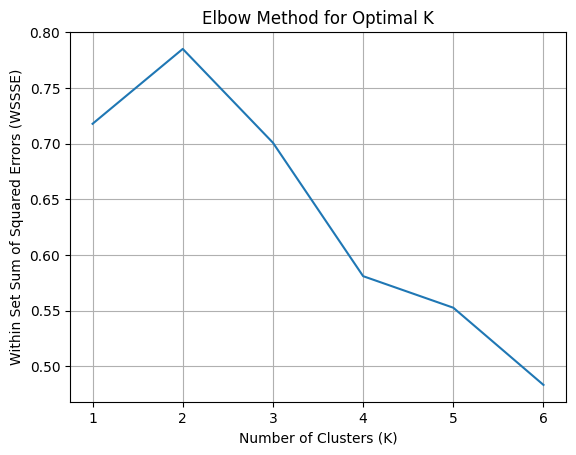

In [24]:

plt.plot(range(1, 7), wssse_values)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

### Visualizing the clusters

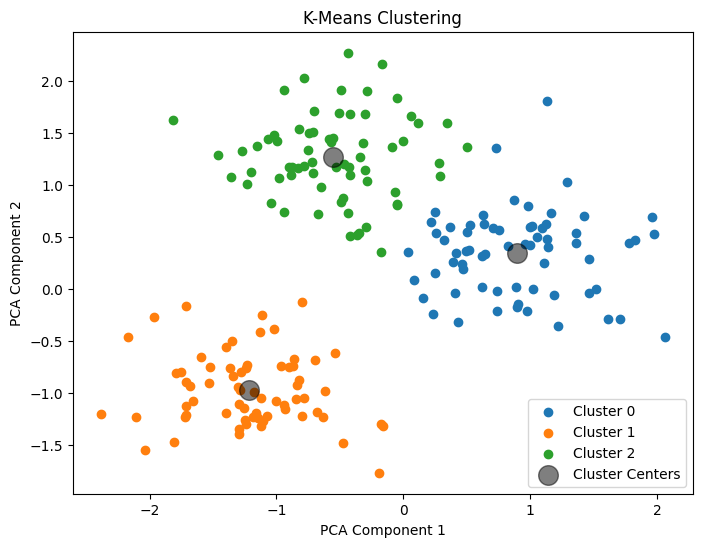

In [25]:
# Visualize the clusters
plt.figure(figsize=(8, 6))
for i in range(3):
    cluster_data = predictions.filter(predictions["cluster"] == i).select("scaled_features").collect()
    cluster_points = [point[0] for point in cluster_data]
    plt.scatter(*zip(*cluster_points), label=f"Cluster {i}")

plt.scatter(*zip(*model.clusterCenters()), c='black', s=200, alpha=0.5, label="Cluster Centers")
plt.title("K-Means Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()